# Lane Detection Project

In this project you need to construct computer vision solution for a lane detection. We are going to implement [LaneNet](https://arxiv.org/pdf/1802.05591.pdf) paper. Our solution is going to have the following parts:

1. Lane semantic segmentation and metric learning
2. Instance segmentation over embedings
3. Homography prediction
4. Lane fitting

We are going to use [TuSimple](https://github.com/TuSimple/tusimple-benchmark/issues/3) dataset for a lane detection.

Let's discuss every step in details.

## Semantic and Instance Segmentation

In this part you should implement and train neural network with the 2 heads. The model should take as an input image and returns to masks. One head should predict *semantic segmentation* and another head should predict *embedding for each pixel*. Pixels that are part of one lane should have similar embeddings, on the other hand pixels from different lanes should have high distance between embeddings. In order to do that, we should implement *discriminative loss*.

After training the discribed network, we can threshold pixels of the interest and cluster them according to the embedding with the *DBSCAN*.

After solving the problem you should obtain the following result. 

## Homograpy Prediction

In order to solve the problem, we would like to understand an exact lane geometry. We are going to describe the lane with the 2-nd order polynom $ax^2 + bx + c$. 

In the image plane lines are not parallel and we may need higher order polynoms to discribe the lane geometry. In order to avoid that we could project image in the bird's eye view with the homography. But drivable surface has different properties over frames, so we would like to condition the homography on the image.

In order to do that, we going to train separate network to predict the best homography for each image.

## Lane Fitting

After predicting homography and lane's clustering we will fit 2-nd order polynom for each lane to obtain the final result. Lane fitting can be formulated as a least-squares problem, where we have points $\{x_i, y_i\}_{i=1}^n$ and we would like to estimation coefficients $a, b, c$ s.t.

$$
\sum_{i = 1}^n ||y_i - a x_i^2 - bx_i - c||^2 \rightarrow \min_{a, b,c}
$$



## Important Notes
0. During the project we provide the relevant papers. Reading the papers can be very helpful (and sometimes necessary) to implement the code.
1. During the project we provide you with the code templates that you should fill.
2. Homography Prediction and Instance Segmentation can be done in parallel.
3. You are free to use any other environment instead of Google Colab.
4. You can deviate from the original papers if it helps you to solve the problem, but you should explain your solution and motivation in the text block.

## Semantic and Segmentation Code

You can use the following commands to download the dataset and unpack it. But we suggest to upload the data to the Google Drive, with Google Drive you will be able to access the data much faster.

In [ ]:
#!mkdir -p /data/tusimple
#!wget https://s3.us-east-2.amazonaws.com/benchmark-frontend/datasets/1/train_set.zip
#!unzip train_set.zip -d /data/tusimple  #

# New Section

In [ ]:
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#!unzip /content/drive/MyDrive/train_set.zip -d /content/drive/MyDrive

In the following cell you should implement pytorch Dataset to generate training examples for instance and semantic segmentation. You are able to modify the signatures if you want.

To implement the LaneDataset you should become familiar with the labeling format.

The dataset is relatively small, so it is important to implement different augmentation strategies. We suggest to use random flips and color augmentations (brightness, saturation). You can also use augmentations of your choice. Augmentations are not required to obtain a full grade but without them your model could overfit dramatically.

NOTE: It can be useful to generate binary segmentation and instance segmentation ground truth once and then use it as-is in every experiment.

In [ ]:
data_path = '/content/drive/MyDrive/'

train_info =  data_path + 'label_data_0313.json'
val_info = data_path + 'label_data_0531.json'
test_info = data_path + 'label_data_0601.json'


/content/drive/MyDrive/clips/0313-1/6040/20.jpg
(720, 1280, 3)


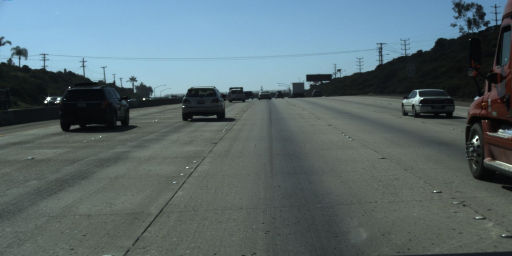

In [ ]:
# read each line of json file
json_gt = [json.loads(line) for line in open(train_info)]
gt = json_gt[0]
gt_lanes = gt['lanes']
y_samples = gt['h_samples']
raw_file = data_path + gt['raw_file']

print(raw_file)

img = cv2.imread(raw_file)
print(img.shape)
cv2_imshow(cv2.resize(img, (512, 256), interpolation=cv2.INTER_LINEAR))

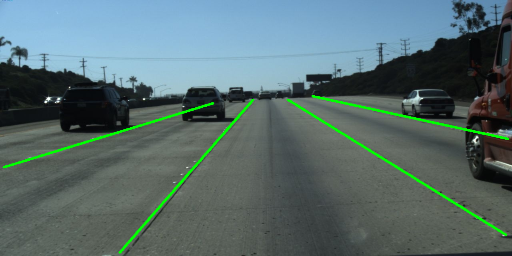

(256, 512, 3) uint8


In [ ]:
gt_lanes_vis = [[(x, y) for (x, y) in zip(lane, y_samples)
                  if x >= 0] for lane in gt_lanes]
img_vis = img.copy()

for lane in gt_lanes_vis:
    img2 = cv2.polylines(img_vis, np.int32([lane]), isClosed=False,
                   color=(0,255,0), thickness=5)
    
img2 = cv2.resize(img2, (512, 256), interpolation=cv2.INTER_LINEAR)
cv2_imshow(img2)
print(img2.shape, img.dtype)
    

(720, 1280, 3) (720, 1280, 3)


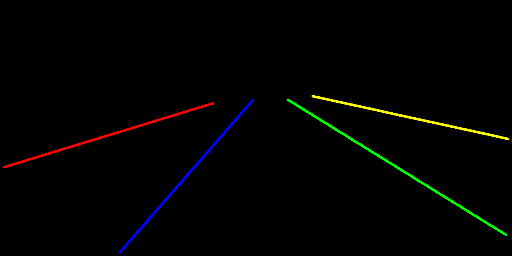

(720, 1280)


In [ ]:
mask = np.zeros_like(img)
print(img.shape, mask.shape)
colors = [[255,0,0],[0,255,0],[0,0,255],[0,255,255]]
for i in range(len(gt_lanes_vis)):
    cv2.polylines(mask, np.int32([gt_lanes_vis[i]]), isClosed=False,color=colors[i], thickness=5)

cv2_imshow(cv2.resize(mask, (512, 256), interpolation=cv2.INTER_LINEAR))

# create grey-scale label image
label = np.zeros((720,1280),dtype = np.uint8)
for i in range(len(colors)):
   label[np.where((mask == colors[i]).all(axis = 2))] = i+1

print(label.shape)

In [ ]:
DEFAULT_SIZE = (256, 512)
IMG_SIZE = (720, 1280)

import torch

class LaneDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True, size=DEFAULT_SIZE):
        self.img_size = size
        self.train_flag = train
        self.data = []
        self.data_path = dataset_path

        if train:
          self.file_path = data_path + 'label_data_0313.json'
        else:
          self.file_path = data_path + 'label_data_0601.json'

        json_gt = [json.loads(line) for line in open(self.file_path)]

        for i in range(len(json_gt)):
          if i%100 == 0:
            print("%i in %i" % (i, len(json_gt)))
          one_sample = dict()

          data_item = json_gt[i]
          gt_lanes = data_item['lanes']
          y_samples = data_item['h_samples']
          raw_file = self.data_path + data_item['raw_file']

          # get image
          img = cv2.imread(raw_file)
          img_resized = cv2.resize(img, (self.img_size[1], self.img_size[0]), interpolation=cv2.INTER_LINEAR)
          one_sample['image'] = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

          # get binary gt
          mask = np.zeros((720,1280),dtype = np.uint8)

          gt_lanes_vis = [[(x, y) for (x, y) in zip(lane, y_samples)
                  if x >= 0] for lane in gt_lanes]
          for lane in gt_lanes_vis:
               cv2.polylines(mask, np.int32([lane]), isClosed=False,
                   color=(1), thickness=5)
          one_sample['bin_gt'] = cv2.resize(mask, (self.img_size[1], self.img_size[0]), interpolation=cv2.INTER_LINEAR)

          # get segmentation gt
          mask = np.zeros((720,1280, 3),dtype = np.uint8)
          colors = [[255,0,0],[0,255,0],[0,0,255],[0,255,255]]
          for i in range(len(gt_lanes_vis)):
              cv2.polylines(mask, np.int32([gt_lanes_vis[i]]), isClosed=False,color=colors[i], thickness=5)

          label = np.zeros((720,1280),dtype = np.uint8)
          for i in range(len(colors)):
            label[np.where((mask == colors[i]).all(axis = 2))] = i+1

          one_sample['seg_img'] = cv2.resize(label, (self.img_size[1], self.img_size[0]), interpolation=cv2.INTER_LINEAR)

        self.data.append(one_sample)

    def __getitem__(self, idx):
        sample = self.data[idx]
        return sample['image'], sample['bin_gt'], sample['seg_img']
    
    def __len__(self):
        return len(self.data)

In [ ]:
ds = LaneDataset(data_path)
ds1 = ds[0]
ds1.shape

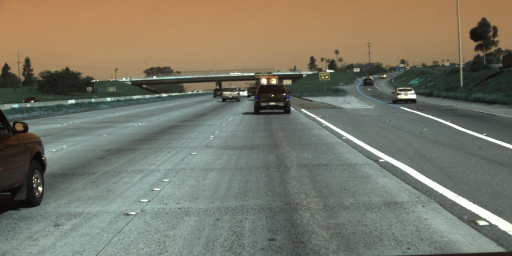

In [ ]:
cv2_imshow(ds1[0])

In [ ]:
ds1[2].shape

(256, 512)

For this task we are going to use ENet architecture. You can read the description in the [original paper](https://arxiv.org/pdf/1606.02147.pdf).

To generate two different outputs we need to have two different branches. In the LaneNet paper authers proposed to share only two first sections of the encoder between to tasks. Third section and decoder should be separate for the instance segmentation and binary segmentation problem.

The output dimension of the instance segmentation embedding should be equal to 5.

In [ ]:
class ENet(nn.Module):
    def __init__(self):
        super(ENet, self).__init__()

    def forward(self, x):
      # TODO
      pass

To obtain the instance segmentation we should train the embeddings as we described in the project description. In order to do that we need to implement [Discriminative Loss](https://arxiv.org/pdf/1708.02551.pdf). Discriminative loss consists of three parts:

1. Inter-cluster push-force: cluster means should be far away from each other
2. Intra-cluster pull-force: embeddings should be close to the center of the corresponding cluster.
3. Regularization: cluster centers should be close to zero.

Corresponding weights for the losses and other hyper-parameters could be found in the paper.

In [ ]:
class DiscriminativeLoss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=True):
        super(DiscriminativeLoss, self).__init__(size_average=size_average)
        # TODO

    def forward(self, input, target):
        # TODO
        pass

Now we are ready to train the network. You may want to create validation subset to track metrics.

In [ ]:
# TODO: Train segmentation and instance segmentation

## Homograpy Prediction Code

Here we again need to implement the Dataset class. Dataset class should return resized image and ground truth points for the lane trajectories.


In [ ]:
HNET_DEFAULT_SIZE = (64, 128)
import torch

class HomographyPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, train=True, size=DEFAULT_SIZE):
        # TODO
        pass

    def __getitem__(self, idx):
        # TODO
        return image, ground_truth_trajectory
    
    def __len__(self):
        # TODO
        pass

Now we need to implement the H-Net. It should return homography matrix that is parametrized by 6 numbers.
Corresponding section is CURVE FITTING USING H-NET in the[ LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

We suggest to follow the paper and take 64x128 image as in input.

Homography projection contains discontinuities, therefore it could be quite difficult to train the network. In order to simplify the problem we propose not to train the homography from scratch, but train some correction to a good starting point.

The following code block contains the initial homography that you can use.


In [ ]:
import torch

# important note: this homography matrix is suitable only for 64x128 resolution
R = torch.Tensor([[-2.0484e-01, -1.7122e+01,  3.7991e+02],
                  [ 0.0000e+00, -1.6969e+01,  3.7068e+02],
                  [ 0.0000e+00, -4.6739e-02,  1.0000e+00]])

Let's check the effect of this homography on the image.

In [ ]:
# !wget https://miro.medium.com/max/2560/1*b3HiwPg69Rw0L5iIMQMXOw.jpeg

In [ ]:
from matplotlib import pyplot as plt
import cv2

In [ ]:
image = plt.imread('1*b3HiwPg69Rw0L5iIMQMXOw.jpeg')

In [ ]:
image = cv2.resize(image, (128, 64))

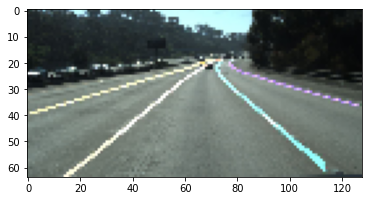

In [ ]:
plt.imshow(image)

In [ ]:
R_np = R.numpy()

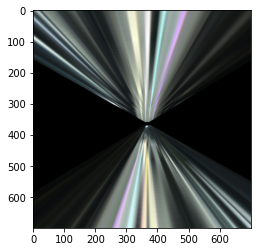

In [ ]:
plt.imshow(cv2.warpPerspective(image, R_np, dsize=(700, 700)))

As you can see it looks like a bird's eye view projection where lines are becoming parallel.

In [ ]:
class HNet(nn.Module):
    def __init__(self):
        super(HNet, self).__init__()
        # TODO
    def forward(self, x):
      # TODO
      pass

Finally, we need to implement the loss to fit the network. This is the most difficult part of the project. Homography loss should do the following:

1. Project ground truth trajectory to the new plane according to the homography to obtain $(x', y')$.
2. Perform polynomial fitting $x' = f(y')$. Your code should work correctly with 2-nd and 3-rd order polynomials. Polynomial fitting should be done with the closed-form solution: $w = (Y^TY)^{-1}Y^Tx$ to be able to pass a gradient through. 
3. Compute back projection with the inverse homography.
4. Compute loss between back projected $\hat{x}$ and ground truth $x$.

The full description can be found in the [LaneNet paper](https://arxiv.org/pdf/1802.05591.pdf).

**IMPORTANT NOTES**

* To fit the polynomial you need to compute the inverse matrix. Computation of the inverse is computation unstable operation. With the help of the SVD you can compute pseudo-inverse matrix: $(X^TX)^{-1}X^T$. In torch this function is called `torch.pinverse`.
* After projection use of the raw $y'$ can be impractical. The features for the polynomial fitting could have a high correlation and therefore solution can be unstable. At first, you need to map $y'$ to some fixed size segment and only then perform a fit.
* After projection some points can occur on the other side of image (bottom part of the projection in the example above). You may want to exclude them, because otherwise polynomial is not going to have much sense and gradients can have a dramatically large values. Positive $w$ in homogeneous coordinates indicates that point is on the wrong side.
* If use the homography provided above, your ground truth should have the same scale, as an image
* Every division in your network is a potential place to obtain `nan` in gradients. Use the following trick to obtain less divisions:
after computing the projection, remember the $w$. Then, before the back projection, multiply your vector by $w$. After back projection you will see that $w$ is equal to 1. So you don't need to devide your vector by $w$.
* You correction to the initial homography could be very big and can completely spoil the homography. So you may need to scale the output of the last layer in the HNet to obtain a smaller corrections.


In [ ]:
class HomographyLoss(torch.nn.modules.loss._Loss):
    def __init__(self, size_average=True):
        super(HomographyLoss, self).__init__(size_average=size_average)

    def forward(self, input, target):
        # TODO
        pass

Finally, train the homography net with the 2-nd order polynomial fitting (you can 3-rd order but we found out that it is much easier to train h-net with the 2-nd order polynomials).

We found out that SGD fits much better for this architectures. Adam (and momentums inside) can ruin the weights because of the discontinuities in the target function surface.

Demonstrate the difference in homography loss between h-net and provided fixed homography on the validation samples.

In [ ]:
# Train the H-Net

# Complete Pipeline

Now you need to implement a class that takes image and a set of $y$ coordinates as an input and returns the $x$ coordinate for each lane in this image.

It should contain the following steps:

1. Apply segmentation network to the image
2. Run DBSCAN over the embeddings for those pixels that are lanes.
3. Apply h-net to the image
4. Project pixel coordinates with the predicted homograpgy
5. Fit the 3-rd order polynomial
6. Predict the lane position for each provided $y$ (you should project this first).
7. Compute back projection and return the positions of $x$ for each lane.

Note: if you weren't able to train the H-Net, you can use the fixed homography here.

In [ ]:
class LaneDetector:
  def __init__(self, hnet, lanenet):
    pass
  
  def __call__(self, image, y_positions):
    pass